#==========================================================================================
#   Jupyter Notebook: Commercial Flight Safety Analysis & Plotting
#   Date: 4/20/2025S

#   This notebook combines:
#     1) Analysis:
#        - Loads data
#        - Cleans/Explodes/Filters
#        - Computes SeverityScore
#        - Runs ANOVA
#        - Saves processed CSV outputs

#     2) Plotting:
#        - Reads the CSV outputs
#        - Produces time-trend plots, distribution plots, and choropleth maps
#        - Allows interactive selection of factors for a violin plot & stacked bar chart



#==========================================================================================
# 1) Setup and Imports

In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline

csv_path = "https://raw.githubusercontent.com/NickDarden95/FinalMSIM625/main/cases2025-03-25_23-11.csv"
allflights = "https://raw.githubusercontent.com/NickDarden95/FinalMSIM625/main/us_total_flight_operations_2005_2025_filtered.csv"

df = pd.read_csv(csv_path)
fdf = pd.read_csv(allflights)

#==========================================================================================
# 2) Define Helper Functions

These functions exist as a method to break apart columns that contain multiple aircraft in an incident as a way to parse out each individual aircraft for analysis.





In [9]:

def split_multi_value_columns(row, columns):
    row_dict = row.to_dict()
    split_lists = []
    for col in columns:
        original_value = row_dict.get(col, "")
        if pd.isna(original_value):
            original_value = ""
        val_str = str(original_value)
        if "," in val_str:
            items = [x.strip() for x in val_str.split(",")]
        else:
            items = [val_str]
        split_lists.append(items)
    max_len = max(len(lst) for lst in split_lists)
    exploded_rows = []
    for i in range(max_len):
        new_row = dict(row_dict)
        for col, items in zip(columns, split_lists):
            new_value = items[i] if i < len(items) else ""
            new_row[col] = new_value
        exploded_rows.append(new_row)
    return exploded_rows

def explode_by_columns(df, multi_cols):
    all_exploded_rows = []
    for _, row in df.iterrows():
        exploded = split_multi_value_columns(row, multi_cols)
        all_exploded_rows.extend(exploded)
    return pd.DataFrame(all_exploded_rows)

# 3) Define columns to parse out for analysis.

Print headers for reference.

In [10]:
    print(df.head(0))

Empty DataFrame
Columns: [NtsbNo, EventType, Mkey, EventDate, City, State, Country, ReportNo, N#, SerialNumber, HasSafetyRec, Mode, ReportType, OriginalPublishedDate, DocketOriginalPublishedDate, HighestInjuryLevel, FatalInjuryCount, SeriousInjuryCount, MinorInjuryCount, OnboardInjuryCount, OnGroundInjuryCount, ProbableCause, Findings, EventID, Latitude, Longitude , Make, Model, AirCraftCategory, AirportID, AirportName, AmateurBuilt, NumberOfEngines, EngineType, Scheduled, PurposeOfFlight, FAR, AirCraftDamage, WeatherCondition, Operator, BroadPhaseofFlight, ReportStatus, RepGenFlag, MostRecentReportType, DocketUrl, ReportUrl]
Index: []

[0 rows x 46 columns]


Choose Column to break out.

In [11]:
explode_cols = ["N#", "NumberOfEngines"]

Choose factors of interest for ANOVA testing and further visualization

In [12]:
factors = [
    "BroadPhaseAggregate",
    "WeatherCondition",
    "FindingsAggregate",
    "State",
    "City",
    "Make",
    "Model",
    "Operator"
]

Choose columns to exclude in anlaysis for efficency.

In [13]:
excluded = [
    "EventType", "Mkey", "Country", "SerialNumber", "HasSafetyRec",
    "Mode", "OriginalPublishedDate", "DocketOriginalPublishedDate",
    "Latitude", "Longitude", "EventID", "AmateurBuilt", "EngineType",
    "Scheduled", "ReportStatus", "RepGenFlag", "MostRecentReportType",
    "DocketUrl", "ReportNO", "ReportType"
]

#==========================================================================================
# 4) Main Analysis
This block applies the fields specified above to the dataset, normalizes the data by applying a severity value to each incident and finally conducts an ANOVA test on the selected factors to determine the statistical significance of each selected factor.

"Severity" is calculated by summing all recorded levels of injury in an incident multiplied by their recepetive value.
<br>Severity Value:<br>
FATAL   - 0.75<br>
SERIOUS - 0.50<br>
MINOR   - 0.25<br>
NONE    - 0.00

In [14]:
excluded_lower = [kw.lower() for kw in excluded]
columns_to_drop = [col for col in df.columns if col.lower() in excluded_lower]
df_filtered = df.drop(columns=columns_to_drop).fillna("")

df_exploded = explode_by_columns(df_filtered, explode_cols)

df_exploded = df_exploded[
    df_exploded["FAR"].str.contains("121", case=False, na=False) |
    df_exploded["FAR"].str.contains("135", case=False, na=False)
]
df_exploded["Year"] = pd.to_datetime(df_exploded["EventDate"], errors="coerce").dt.year

# Fill injury-level
df_exploded["HighestInjuryLevel"] = (
    df_exploded["HighestInjuryLevel"]
    .replace("", np.nan)
    .fillna("No Injury")
)

# Merge with flight ops for incident counts
incidents_per_year = df_exploded.groupby("Year").size().reset_index(name="Incidents")
merged = pd.merge(incidents_per_year, fdf, on="Year", how="left").fillna(0)

merged["Total Commercial Flights"] = merged["Air Carrier"] + merged["Air Taxi"]
merged["Incidents per Million Flights"] = (
    merged["Incidents"] / merged["Total Commercial Flights"] * 1_000_000
)

# Compute Severity Score
for col in ["FatalInjuryCount", "SeriousInjuryCount", "MinorInjuryCount"]:
    df_exploded[col] = (
        pd.to_numeric(df_exploded[col], errors='coerce')
        .fillna(0)
        .astype(float)
    )

df_exploded["SeverityScore"] = (
    df_exploded["FatalInjuryCount"] * 0.75
    + df_exploded["SeriousInjuryCount"] * 0.5
    + df_exploded["MinorInjuryCount"] * 0.25
)

# Aggregate broad phase of flight
aggregation_map = {
    "Initial Climb":    "Takeoff/Departure",
    "Takeoff":          "Takeoff/Departure",
    "Approach":         "Landing/Arrival",
    "Landing":          "Landing/Arrival",
    "After Landing":    "Landing/Arrival",
    "Enroute":          "Mid-Flight",
    "Maneuvering":      "Mid-Flight",
    "Standing":         "Ground Operations",
    "Pushback/Tow":     "Ground Operations",
    "Taxi":             "Ground Operations"
}
df_exploded["BroadPhaseAggregate"] = (
    df_exploded["BroadPhaseofFlight"].map(aggregation_map).fillna("Unknown")
)

# Drop single-engine aircraft
df_exploded = df_exploded[df_exploded["NumberOfEngines"] != "1"].copy()

# Assign State Abbreviations & drop rows not in the dictionary
state_name_to_abbrev = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR",
    "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE",
    "District of Columbia": "DC", "Florida": "FL", "Georgia": "GA", "Hawaii": "HI",
    "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS",
    "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD",
    "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS",
    "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV",
    "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY",
    "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK",
    "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC",
    "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", "Utah": "UT",
    "Vermont": "VT", "Virginia": "VA", "Washington": "WA", "West Virginia": "WV",
    "Wisconsin": "WI", "Wyoming": "WY"
}

df_exploded.loc[:, "StateAbbrev"] = df_exploded["State"].map(state_name_to_abbrev)
df_exploded = df_exploded.dropna(subset=["StateAbbrev"])

# Save key CSV outputs
merged.to_csv("incidents_normalized.csv", index=False)

severity_by_ntsb = (
    df_exploded.drop_duplicates("NtsbNo")
    .groupby("Year")["SeverityScore"]
    .agg(["mean", "sum"])
    .reset_index()
)
severity_by_ntsb = pd.merge(severity_by_ntsb, fdf, on="Year", how="left").fillna(0)
severity_by_ntsb["Total Commercial Flights"] = (
    severity_by_ntsb["Air Carrier"] + severity_by_ntsb["Air Taxi"]
)
severity_by_ntsb["Severity per Million Flights"] = (
    (severity_by_ntsb["sum"] / severity_by_ntsb["Total Commercial Flights"])
    .fillna(0)
    * 1_000_000
)
severity_by_ntsb.to_csv("severity_by_year.csv", index=False)
df_exploded.to_csv("filtered_cases.csv", index=False)

# Parse out "Findings" + create aggregated factor columns
factor_substring_map = {
    "control parameters": "control parameters",
    "turbulence":         "turbulence",
    "landing gear":       "landing gear",
    "aircraft control":   "aircraft control",
    "power plant":        "power plant",
    "psychological":      "psychological",
    "maintenance":        "maintenance",
    "animal":             "animal",
    "Pilot":              "Pilot",
    "Crew Proficency":    "Task performance"
}

if "Findings" in df_exploded.columns:
    for sub_label in factor_substring_map:
        df_exploded[sub_label] = (
            df_exploded["Findings"]
            .str.contains(factor_substring_map[sub_label], case=False, na=False)
            .astype(int)
        )
else:
    print("WARNING: 'Findings' column not found in df_exploded.")

def aggregate_findings(row):
    active_labels = []
    for k in factor_substring_map:
        if row[k] == 1:
            active_labels.append(k)
    return ",".join(active_labels) if active_labels else "None"

df_exploded["FindingsAggregate"] = df_exploded.apply(aggregate_findings, axis=1)

anova_results = []
ranking_results = []

for factor in factors:
    sub = df_exploded.dropna(subset=["SeverityScore", factor]).copy()
    if sub.empty:
        continue

    unique_vals = sub[factor].unique()
    if len(unique_vals) < 2:
        continue

    sub[factor] = sub[factor].astype("category")
    formula = f"SeverityScore ~ C({factor})"
    model = ols(formula, data=sub).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    F_value = anova_table.loc[f"C({factor})", "F"]
    p_value = anova_table.loc[f"C({factor})", "PR(>F)"]

    anova_results.append({
        "Factor": factor,
        "NumCategories": len(unique_vals),
        "F_value": F_value,
        "p_value": p_value
    })

    group_means = (
        sub.groupby(factor, observed=False)["SeverityScore"]
        .mean()
        .reset_index()
        .rename(columns={"SeverityScore": "MeanSeverityScore"})
    )
    group_means = group_means.sort_values("MeanSeverityScore", ascending=False)
    group_means.insert(0, "Factor", factor)
    ranking_results.append(group_means)

anova_df = pd.DataFrame(anova_results)
anova_df = anova_df.sort_values("p_value", ascending=True).reset_index(drop=True)
anova_df.to_csv("anova_overall_results.csv", index=False)
print("Saved overall ANOVA results to anova_overall_results.csv.")

if ranking_results:
    ranking_final = pd.concat(ranking_results, ignore_index=True)
    ranking_final.to_csv("group_mean_ranking_by_factor.csv", index=False)
    print("Saved group mean ranking results to group_mean_ranking_by_factor.csv.")

print("\n=== Analysis Complete ===")
print("CSV outputs generated, including 'filtered_cases.csv', 'anova_overall_results.csv'.")
print("Now proceed with the plotting steps below.")

df_incidents = pd.read_csv("incidents_normalized.csv")   # "merged"
df_severity = pd.read_csv("severity_by_year.csv")        # "severity_by_ntsb"
df_exploded = pd.read_csv("filtered_cases.csv")          # final main dataset
anova_df = pd.read_csv("anova_overall_results.csv")      # ANOVA results

print("Data loaded. Plot Generation Ready...")

Saved overall ANOVA results to anova_overall_results.csv.
Saved group mean ranking results to group_mean_ranking_by_factor.csv.

=== Analysis Complete ===
CSV outputs generated, including 'filtered_cases.csv', 'anova_overall_results.csv'.
Now proceed with the plotting steps below.
Data loaded. Plot Generation Ready...


#==========================================================================================
# 5) Visualization

Time Trend: Incidents per Million Flights

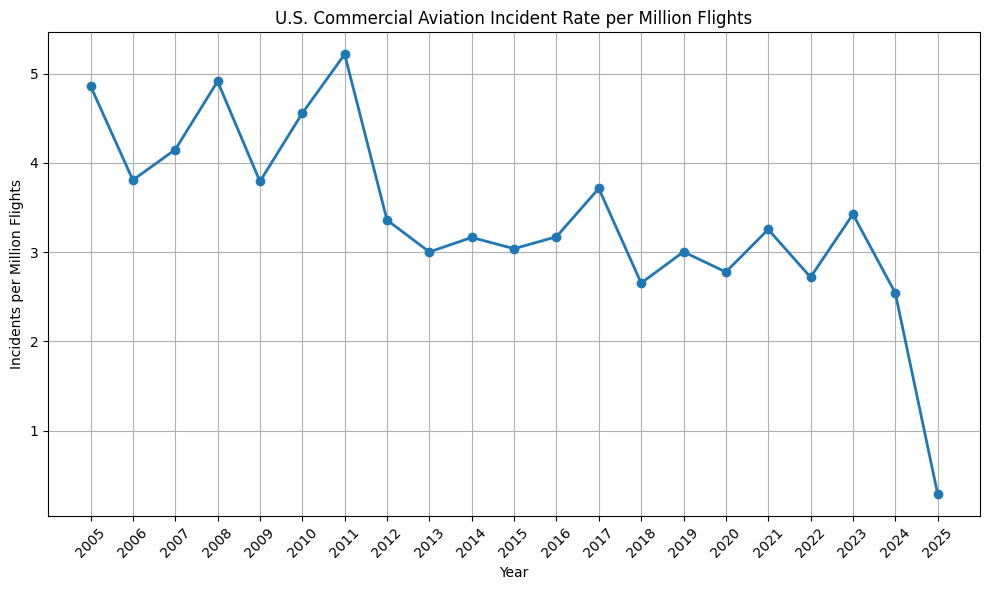

In [15]:

plt.figure(figsize=(10, 6))
plt.plot(
    df_incidents["Year"],
    df_incidents["Incidents per Million Flights"],
    marker="o",
    linewidth=2
)
plt.title("U.S. Commercial Aviation Incident Rate per Million Flights")
plt.xlabel("Year")
plt.ylabel("Incidents per Million Flights")
plt.xticks(df_incidents["Year"], rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Distribution: Highest Injury Level

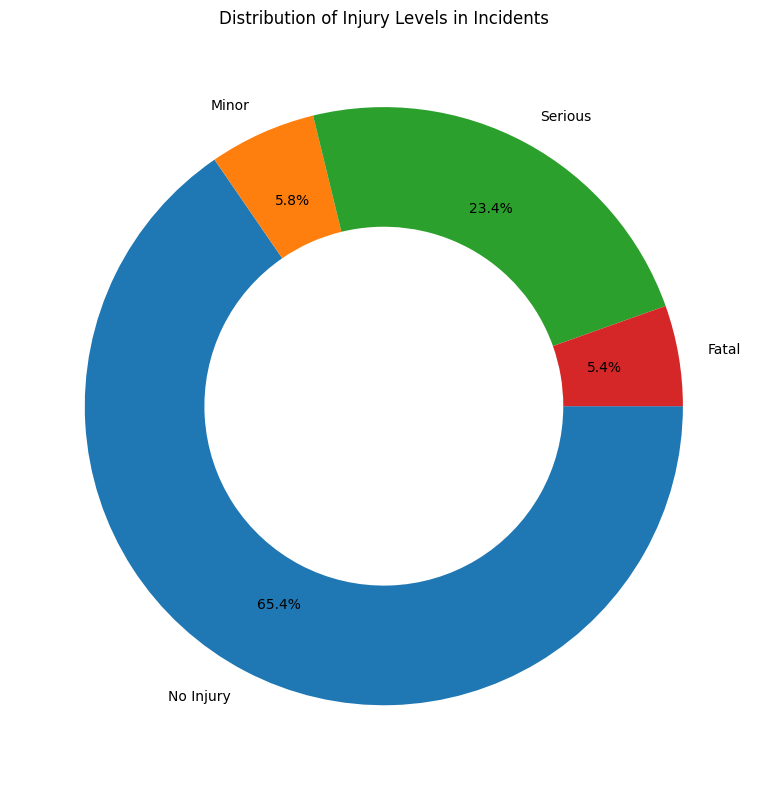

In [16]:
injury_counts = df_exploded["HighestInjuryLevel"].value_counts()
plt.figure(figsize=(8, 8))
ordered_labels = ["No Injury", "Minor", "Serious", "Fatal"]
ordered_counts = [injury_counts.get(label, 0) for label in ordered_labels]
plt.pie(
    ordered_counts,
    labels=ordered_labels,
    autopct='%1.1f%%',
    startangle=0,
    counterclock=False,
    wedgeprops={'width': 0.4},
    pctdistance=0.75
)
plt.title("Distribution of Injury Levels in Incidents")
plt.tight_layout()
plt.show()

Average Severity Score by Year

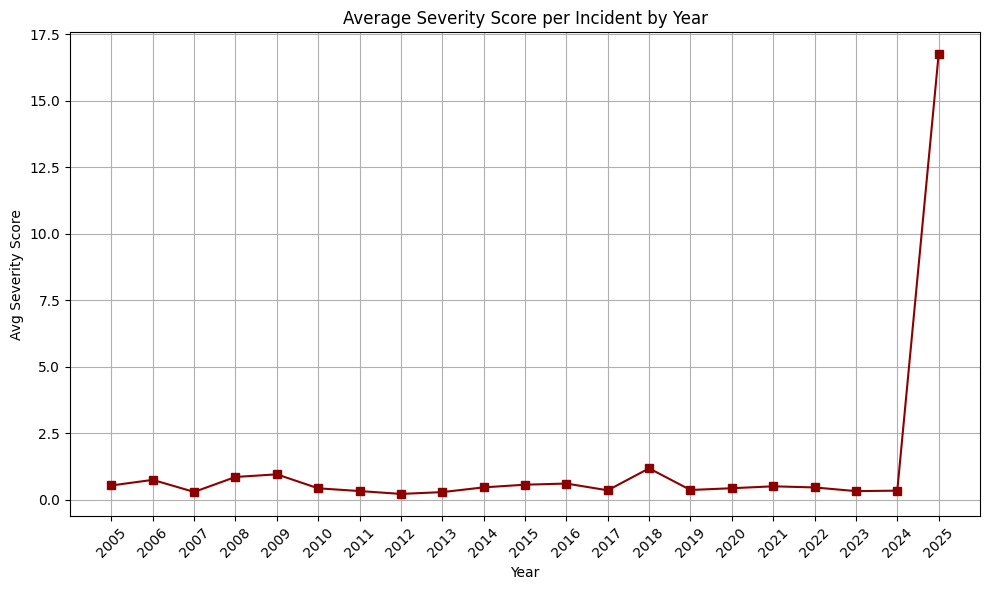

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(
    df_severity["Year"],
    df_severity["mean"],
    marker="s",
    color="darkred"
)
plt.title("Average Severity Score per Incident by Year")
plt.xlabel("Year")
plt.ylabel("Avg Severity Score")
plt.xticks(df_severity["Year"], rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Severity per Million Flights by Year

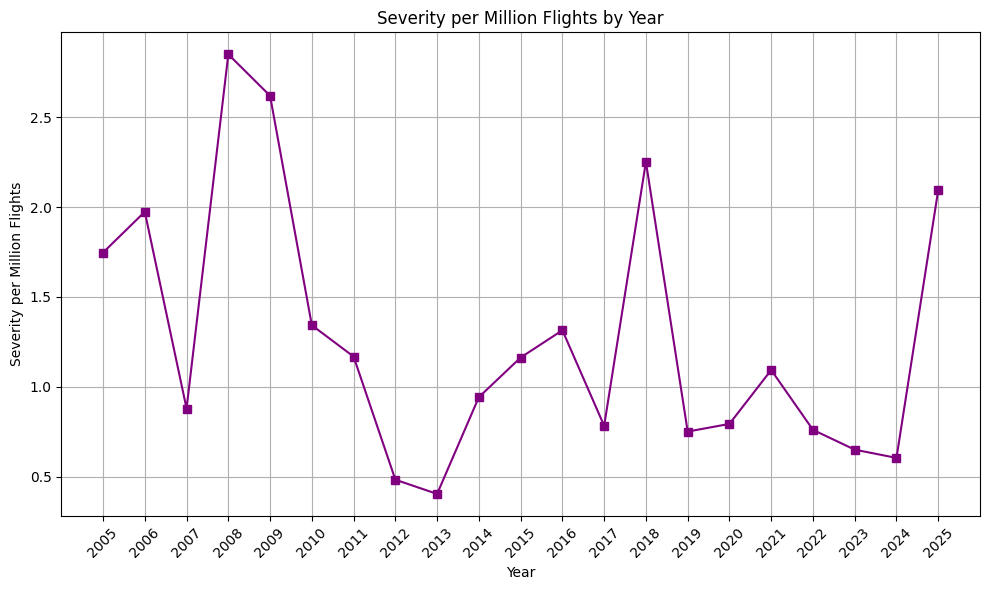

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(
    df_severity["Year"],
    df_severity["Severity per Million Flights"],
    marker="s",
    color="purple"
)
plt.title("Severity per Million Flights by Year")
plt.xlabel("Year")
plt.ylabel("Severity per Million Flights")
plt.xticks(df_severity["Year"], rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

State-Level Choropleths

In [19]:
df_state = df_exploded.dropna(subset=["StateAbbrev", "Year"]).copy()
df_by_state = (
    df_state.groupby(["StateAbbrev", "Year"], observed=False)["SeverityScore"]
    .sum()
    .reset_index()
)

severity_min = df_by_state["SeverityScore"].min()
severity_max = df_by_state["SeverityScore"].max()

fig_choropleth = px.choropleth(
    df_by_state,
    locations="StateAbbrev",
    locationmode="USA-states",
    color="SeverityScore",
    scope="usa",
    animation_frame="Year",
    color_continuous_scale="OrRd",
    range_color=(severity_min, severity_max),
    labels={"SeverityScore": "Severity"},
    title="U.S. States Incident Severity by Year (Summed)"
)
fig_choropleth.show()

df_all_years = (
    df_by_state.groupby("StateAbbrev", observed=False)["SeverityScore"]
    .sum()
    .reset_index()
)
severity_min_all = df_all_years["SeverityScore"].min()
severity_max_all = df_all_years["SeverityScore"].max()

fig_choropleth_all = px.choropleth(
    df_all_years,
    locations="StateAbbrev",
    locationmode="USA-states",
    color="SeverityScore",
    scope="usa",
    color_continuous_scale="OrRd",
    range_color=(severity_min_all, severity_max_all),
    labels={"SeverityScore": "Severity (All Years)"},
    title="U.S. States Incident Severity (All Years Summed)"
)
fig_choropleth_all.show()

#6.) Factor Plots


--- ANOVA Results (From 'anova_overall_results.csv') ---
All tested factors with p-values:
 1. Make (p=0.00000)
 2. Model (p=0.00000)
 3. Operator (p=0.00000)
 4. State (p=0.00000)
 5. BroadPhaseAggregate (p=0.05633)
 6. City (p=0.74628)
 7. FindingsAggregate (p=0.86153)
 8. WeatherCondition (p=0.92716)

Enter the number of the factor you'd like to plot (e.g., '1'): 5

Using factor: BroadPhaseAggregate


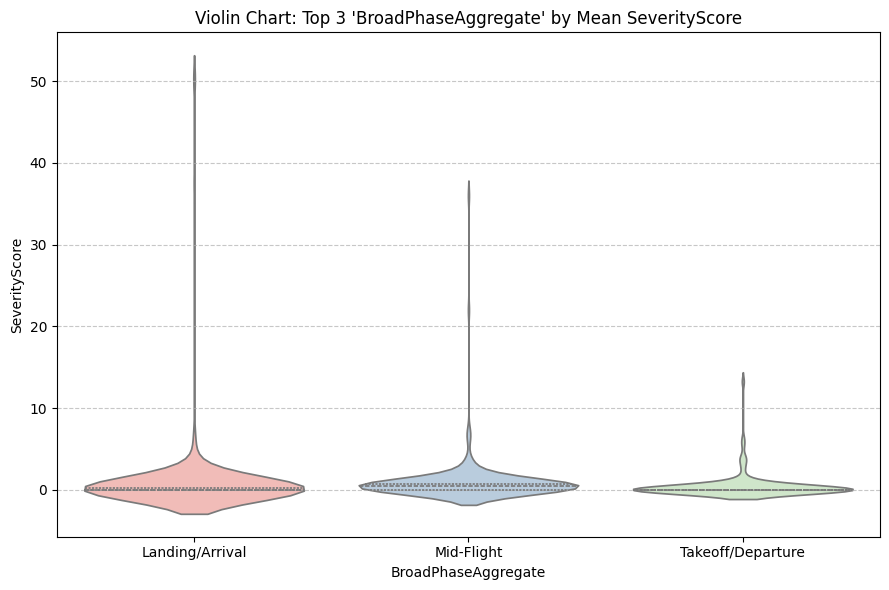

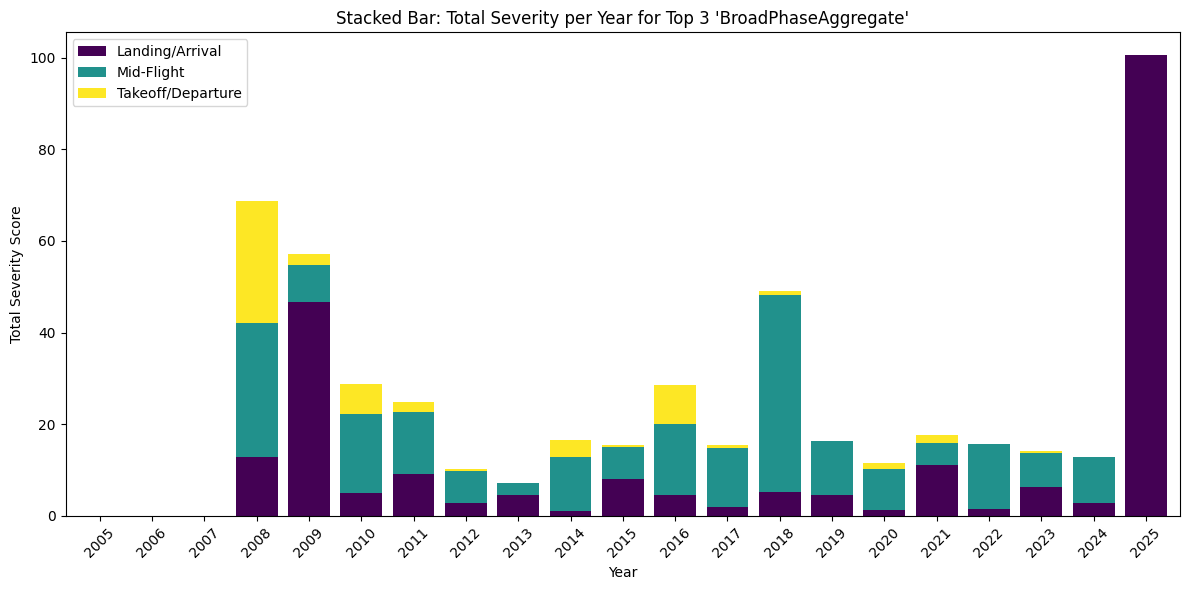


=== Plotting Complete. ===


In [20]:
# 4F. Interactive Choice of Factor for Violin & Stacked Bar Chart
if anova_df.empty:
    print("No ANOVA results found in 'anova_overall_results.csv'. Exiting.")
else:
    anova_df_sorted = anova_df.sort_values("p_value", ascending=True).reset_index(drop=True)

    print("\n--- ANOVA Results (From 'anova_overall_results.csv') ---")
    print("All tested factors with p-values:")
    for i, row in anova_df_sorted.iterrows():
        fct, p_val = row["Factor"], row["p_value"]
        print(f" {i+1}. {fct} (p={p_val:.5f})")

    choice = input("\nEnter the number of the factor you'd like to plot (e.g., '1'): ")
    try:
        choice_idx = int(choice) - 1
        if choice_idx < 0 or choice_idx >= len(anova_df_sorted):
            raise ValueError
        selected_factor = anova_df_sorted.loc[choice_idx, "Factor"]
    except ValueError:
        print("Invalid choice, defaulting to the first row in anova_df.")
        selected_factor = anova_df_sorted.loc[0, "Factor"]

    print(f"\nUsing factor: {selected_factor}")

    df_factor = df_exploded.dropna(subset=["SeverityScore", selected_factor]).copy()

    # Identify top 3 categories by mean SeverityScore
    top_categories = (
        df_factor[df_factor[selected_factor] != "Unknown"]
        .groupby(selected_factor, observed=False)["SeverityScore"]
        .mean()
        .sort_values(ascending=False)
        .head(3)
        .index
    )
    df_top3 = df_factor[df_factor[selected_factor].isin(top_categories)].copy()

    # --- Violin Chart ---
    plt.figure(figsize=(9, 6))
    sns.violinplot(
        data=df_top3,
        x=selected_factor,
        y="SeverityScore",
        hue=selected_factor,
        dodge=False,
        inner="quartile",
        palette="Pastel1",
        legend=False
    )
    plt.title(f"Violin Chart: Top 3 '{selected_factor}' by Mean SeverityScore")
    plt.xlabel(selected_factor)
    plt.ylabel("SeverityScore")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # --- Stacked Bar Chart ---
    pivot_severity = (
        df_top3.groupby(["Year", selected_factor], observed=False)["SeverityScore"]
        .sum()
        .unstack(fill_value=0)
    )

    all_years = sorted(df_factor["Year"].dropna().unique())
    pivot_severity = pivot_severity.reindex(all_years, fill_value=0)
    pivot_severity = pivot_severity.sort_index()

    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    pivot_severity.plot(
        kind="bar",
        stacked=True,
        colormap="viridis",
        ax=ax,
        width=0.8
    )
    ax.set_xticklabels(pivot_severity.index, rotation=45)
    ax.set_title(
        f"Stacked Bar: Total Severity per Year for Top 3 '{selected_factor}'"
    )
    ax.set_xlabel("Year")
    ax.set_ylabel("Total Severity Score")
    ax.legend(loc="best")
    plt.tight_layout()
    plt.show()

print("\n=== Plotting Complete. ===")